# Starbucks Capstone Challenge

### Introduction & Business Understanding¶

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Questions we want to Answer:

The business questions that the project seeks to answer are :

- Demographics Questions
    - how do demographics influence the type of offer given
    - how do demographics influence the channels that a customer uses to complete an offer
    - how do demogrpahics influence the customers completing offers of various durations
    - how do demographics influence the customers in completing offers with various rewards
    - how do demographics of customers interact with difficulty (min required spend to complete an offer) of offers
    
- Key Driver Analysis
Which factors influence highest to the amount spent by a customer ?

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="utility_images/pic1.png"/>

Then you will want to run the above command:

<img src="utility_images/pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt

from relativeImp import relativeImp
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

## Loading Data

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration & Understanding

In [4]:
portfolio.name, profile.name, transcript.name = 'portfolio', 'profile', 'transcript'

df_list = [portfolio, profile, transcript]

for df in df_list:
    print('Dataframe {0} has {1} rows and {2} columns'.format(df.name, df.shape[0], df.shape[1]))
    print('...')

Dataframe portfolio has 10 rows and 6 columns
...
Dataframe profile has 17000 rows and 5 columns
...
Dataframe transcript has 306534 rows and 4 columns
...


### Portfolio dataset

In [5]:
# viewing columns

portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [6]:
# describing all columns

portfolio.describe(include ='all')

,reward,channels,difficulty,duration,offer_type,id
count,10.000000,10,10.000000,10.000000,10,10
unique,NaN,4,NaN,NaN,3,10
top,NaN,"[web, email, mobile, social]",NaN,NaN,bogo,0b1e1539f2cc45b7b9fa7c272da2e1d7
freq,NaN,4,NaN,NaN,4,1
mean,4.200000,NaN,7.700000,6.500000,NaN,NaN
std,3.583915,NaN,5.831905,2.321398,NaN,NaN
min,0.000000,NaN,0.000000,3.000000,NaN,NaN
25%,2.000000,NaN,5.000000,5.000000,NaN,NaN
50%,4.000000,NaN,8.500000,7.000000,NaN,NaN
75%,5.000000,NaN,10.000000,7.000000,NaN,NaN


### Profile dataset

In [7]:
# view all columns
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


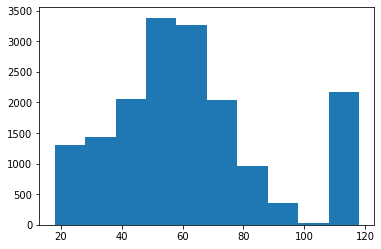

In [8]:
plt.hist(profile['age'])

plt.show()

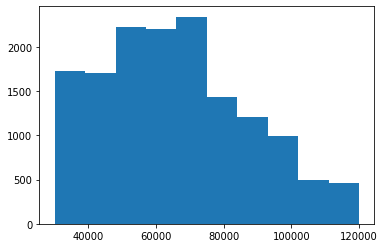

In [9]:
plt.hist(profile['income'])

plt.show()

In [10]:
# describe all columns 

profile.describe(include = 'all')

,gender,age,id,became_member_on,income
count,14825,17000.000000,17000,1.700000e+04,14825.000000
unique,3,NaN,17000,NaN,NaN
top,M,NaN,56c0519eb78d404e8648e0b634648b77,NaN,NaN
freq,8484,NaN,1,NaN,NaN
mean,NaN,62.531412,NaN,2.016703e+07,65404.991568
std,NaN,26.738580,NaN,1.167750e+04,21598.299410
min,NaN,18.000000,NaN,2.013073e+07,30000.000000
25%,NaN,45.000000,NaN,2.016053e+07,49000.000000
50%,NaN,58.000000,NaN,2.017080e+07,64000.000000
75%,NaN,73.000000,NaN,2.017123e+07,80000.000000


### Transcript dataset

In [11]:
# veiw all columns
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [12]:
# describe all columns

transcript.describe(include = 'all')

,person,event,value,time
count,306534,306534,306534,306534.000000
unique,17000,4,5121,NaN
top,94de646f7b6041228ca7dec82adb97d2,transaction,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},NaN
freq,51,138953,14983,NaN
mean,NaN,NaN,NaN,366.382940
std,NaN,NaN,NaN,200.326314
min,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,186.000000
50%,NaN,NaN,NaN,408.000000
75%,NaN,NaN,NaN,528.000000


# Data Pre-processing (Cleaning & Transformations)

### Portfolio Dataset
   We are going to clean and transform the dataset by :
   - transforming the 'channels' column into dummy columns with 1 if the offer uses the channel otherwise 0
   - transforming the 'channel' column from a list of values to a string of values
   - transforming the offer type to also have dummy columns
   - check for any duplicates

In [13]:
def clean_portfolio(df):
    
    """
    Cleans and pre-processes the portfolio dataset
    
    Args:
        portfolio : the portfolio dataframe
        
    Returns:
        df : a cleaned and transformed portfolio dataframe
        
    """
    
    # getting all channel types
    channels = []

    for row in df['channels']:
        for channel in row:
            if channel not in channels:
                channels.append(channel)

    # for each row create a dummy columns with 1 if channel exists otherwise 0
    for channel in channels:
        portfolio[channel] = df['channels'].apply(lambda x: 1 if channel in x else 0)
        
    # get unique values from offer_type
    offer_type_list = df.offer_type.unique()

    # for each row create a dummy columns with 1 if channel exists otherwise 0
    for offer in offer_type_list:
        df[offer] = portfolio['offer_type'].apply(lambda x: 1 if offer in x else 0)
    
    # convert channels list to a string
    df['channels_list'] = df['channels'].apply(lambda x: ','.join(map(str, x)))
    
    # drop channels column
    df.drop(columns ='channels', inplace = True)
    
    
    return df 
    

In [14]:
cleaned_portfolio = clean_portfolio(portfolio)

In [15]:
cleaned_portfolio.head()

,reward,difficulty,duration,offer_type,id,email,mobile,social,web,bogo,informational,discount,channels_list
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,"email,mobile,social"
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0,"web,email,mobile,social"
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,1,0,"web,email,mobile"
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0,"web,email,mobile"
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,0,1,"web,email"


In [17]:
# just confirming we do not have duplicates

portfolio.columns.duplicated()

# all are false which is nice

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False])

### Profile Dataset
 With the profile dataset we are going to perform some cleaning:
   - On the gender, age and income column we are going to check at the no.of NaNs and decide if we are going to drop rows or impute
   - We will also bucket the age column into age buckets to help us for better visualization later
   - We will also bucket the income column into income buckets to help us for better visualization later
   - We will also convert the became member on into a date_time field
   - We will also break the date_field created into its constituent parts (day, month, year) to be used later in the analysis 
   - Also check for duplicates
    

 We see some pattern were we have both the same no of nulls in gender & income columns. So ideally it would make sense to see if the same rows that have null income are the same as those with null gender 

In [18]:
# checking for nulls in the columns
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [19]:
# get rows were income is null
null_income_df = profile[profile['income'].isnull()]

print(null_income_df['gender'].value_counts())
print('...')
print(null_income_df['age'].value_counts())


Series([], Name: gender, dtype: int64)
...
118    2175
Name: age, dtype: int64


In [20]:
# function to get  age buckets 

def get_age_groups(series, bins=(18, 30, 40, 50, 60, 70, 80, 90, 100)):
    
    """
    Divides a column into age buckets according to left closed, right open bins
    
    Parameters: 
            a dataframe column with continous age values
     
    Returns:
            a new column with buckets that have a upper and lower bound
    """

    bins = sorted(bins)

    if bins[0] != 0:
        bins = [0] + bins

    max_age = max(series)
    if max_age > bins[-1]:
        bins = bins + [max_age + 1]

    age_buckets = pd.cut(series, bins = bins, right = False, precision = 0, ordered = True)

    return age_buckets

In [21]:
#create function to bucket amounts

def get_amt_buckets(series, bins=(10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 100000, 110000, 120000, 130000)):
    
    """
    Divides a column into amount buckets according to left closed, right open bins
    
    Parameters: 
            a dataframe column with continous amount values
     
    Returns:
            a new column with buckets that have a upper and lower bound
    """


    bins = sorted(bins)

    if bins[0] != 0:
        bins = [0] + bins

    max_amt = max(series)
    if max_amt > bins[-1]:
        bins = bins + [max_amt + 1]

    amt_buckets = pd.cut(series, bins=bins, precision = 0, right = False, ordered = True)

    return amt_buckets

In [22]:
def clean_profile(df):
    """
    Cleans and pre-processes the profile dataset
    
    Args:
        profile : the profile dataframe
        
    Returns:
        df : cleaned and transformed profile dataframe
      
    """
    
    # dropping all rows where income is null;
    df = df.dropna(axis = 0, subset=['income'])
    
    # drop rows with gender O since it was not described what it really means 
    df = df[df['gender'] != 'O']
    
    #create dummy variables for gender
    gender_dummies = pd.get_dummies(df['gender']).rename(columns = lambda x : 'gender_' + str(x))
    
    df = pd.concat([df, gender_dummies] , axis = 1)
    
    # create date_time column for when person became a member
    df['date_became_member'] = df.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
    
    # break down the date to day, month, year
    df['year_became_member']= df['date_became_member'].dt.year
    df['month_became_member']= df['date_became_member'].dt.month
    df['day_became_member']= df['date_became_member'].dt.day
    
    #create age buckets column
    df['age_group'] = get_age_groups(df['age'])
  
    #create an income buckets column;
    df['income_bucket'] = get_amt_buckets(df['income'])
  
    return df

In [23]:
print(profile.info())
print('\n...\n')
print(profile.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None

...

(17000, 5)


In [24]:
profile.describe(include = 'all')

,gender,age,id,became_member_on,income
count,14825,17000.000000,17000,1.700000e+04,14825.000000
unique,3,NaN,17000,NaN,NaN
top,M,NaN,56c0519eb78d404e8648e0b634648b77,NaN,NaN
freq,8484,NaN,1,NaN,NaN
mean,NaN,62.531412,NaN,2.016703e+07,65404.991568
std,NaN,26.738580,NaN,1.167750e+04,21598.299410
min,NaN,18.000000,NaN,2.013073e+07,30000.000000
25%,NaN,45.000000,NaN,2.016053e+07,49000.000000
50%,NaN,58.000000,NaN,2.017080e+07,64000.000000
75%,NaN,73.000000,NaN,2.017123e+07,80000.000000


In [25]:
# Check for duplicates in all columns
profile.columns.duplicated()

# all are false which is nice!

array([False, False, False, False, False])

In [26]:
cleaned_profile = clean_profile(profile)

In [27]:
cleaned_profile.head()

,gender,age,id,became_member_on,income,gender_F,gender_M,date_became_member,year_became_member,month_became_member,day_became_member,age_group,income_bucket
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,0,2017-07-15,2017,7,15,"[50, 60)","[110000, 120000)"
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1,0,2017-05-09,2017,5,9,"[70, 80)","[100000, 110000)"
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,0,1,2018-04-26,2018,4,26,"[60, 70)","[70000, 80000)"
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,0,1,2018-02-09,2018,2,9,"[60, 70)","[50000, 60000)"
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,0,1,2017-11-11,2017,11,11,"[50, 60)","[50000, 60000)"


In [28]:
print(cleaned_profile.info())
print('\n...\n')
print(cleaned_profile.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14613 entries, 1 to 16999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   gender               14613 non-null  object        
 1   age                  14613 non-null  int64         
 2   id                   14613 non-null  object        
 3   became_member_on     14613 non-null  int64         
 4   income               14613 non-null  float64       
 5   gender_F             14613 non-null  uint8         
 6   gender_M             14613 non-null  uint8         
 7   date_became_member   14613 non-null  datetime64[ns]
 8   year_became_member   14613 non-null  int64         
 9   month_became_member  14613 non-null  int64         
 10  day_became_member    14613 non-null  int64         
 11  age_group            14613 non-null  category      
 12  income_bucket        14613 non-null  category      
dtypes: category(2), datetime64[ns](

### Transcript Dataset

 For the transcript dataset we are going to:
 
 - break down the dicts on the value columns into key and value to have two columns
 - check for duplicates
 - rename 'person' column to customer_id
 - check for missing data and handle that

In [29]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [30]:
def clean_transcript(df):
    
    """
    Cleans and pre-processes the transcript dataset
    
    Args:
        transcript : the transcript dataframe
        
    Returns:
        df : cleaned and transformed transcript dataframe
      
    """
  
    # transform value column into  different columns based on the dicts
    dict_columns = pd.DataFrame(df['value'].values.tolist(), index = df.index)
    df = pd.merge(df, dict_columns, left_index=True, right_index=True)
    
    # merge offer_id and offer id columns
    df.loc[df['offer_id'].isnull(), 'offer_id'] = df['offer id']
    
    # drop the value and offer id columns as they are redundant
    df.drop(columns = ['value', 'offer id'], inplace = True)
    
    # rename column 'person'
    df.rename(columns = {'person': 'customer_id'}, inplace = True)
    
    # drop duplicates
    df.drop_duplicates(inplace=True)
    
    return df

In [31]:
#create a cleaned transcript dataset
cleaned_transcript = clean_transcript(transcript)

In [32]:
cleaned_transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306137 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_id  306137 non-null  object 
 1   event        306137 non-null  object 
 2   time         306137 non-null  int64  
 3   amount       138953 non-null  float64
 4   offer_id     167184 non-null  object 
 5   reward       33182 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 16.3+ MB


 #### _We are now going to create a function to merge the 3 datasets together_

In [33]:
def merge_datasets(cleaned_portfolio, cleaned_profile, cleaned_transcript):
    
    """
    Merges the cleaned dataframes into one dataframe
    
    Args:
        cleaned_portfolio: cleaned portfolio dataframe
        cleaned_profile: cleaned profile dataframe
        cleaned_transcript: cleaned transcript dataframe
    
    Returns:
        full_df: a combined dataframe with columns from all the three dataframes
    
    """
    
    # merge the 3 datasets based on keys
    full_df = pd.merge(
        pd.merge(cleaned_transcript, cleaned_profile, how = 'inner', left_on = 'customer_id', right_on = 'id'),
             cleaned_portfolio, how ='left', left_on = 'offer_id', right_on = 'id')
    
    # delete unwanted keys
    full_df.drop(['id_x', 'id_y'], axis = 1, inplace = True)
    
    # rename column 'person'
    full_df.rename(columns = {'reward_x': 'transcript_reward', 'reward_y' : 'portfolio_reward'}, inplace = True)
    
    return full_df

In [34]:
full_df = merge_datasets(cleaned_portfolio, cleaned_profile, cleaned_transcript)

In [35]:
full_df.head()

,customer_id,event,time,amount,offer_id,transcript_reward,gender,age,became_member_on,income,...,duration,offer_type,email,mobile,social,web,bogo,informational,discount,channels_list
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,20170509,100000.0,...,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0,"web,email,mobile"
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,20170509,100000.0,...,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0,"web,email,mobile"
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,NaN,NaN,F,75,20170509,100000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,F,75,20170509,100000.0,...,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0,"web,email,mobile"
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,NaN,NaN,F,75,20170509,100000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
#check if we have any duplicates 
full_df.columns.duplicated().sum()

0

### _Function to get subset of data based on event type_

In [37]:
# function to get data on offers
def subset_events(full_df):
    """
    Subsets the full dataset into the different events that can occur
    
    Args:
        full_df: dataframe containing all the data 
        
    Returns: 
        offer_recieved_df: dataframe of recieived offers  
        offer_viewed_df:  dataframe of viewed offers
        offer_completed_df: dataframe of offers completed
        transaction_df: dataframe of transactions done by customer    
    
    """ 
    
    # subset the data based on event type column
    offer_recieved_df = full_df[full_df['event'] == 'offer received']
    
    offer_viewed_df = full_df[full_df['event'] == 'offer viewed']
    
    offer_completed_df = full_df[full_df['event'] == 'offer completed']
    
    transaction_df = full_df[full_df['event'] == 'transaction']
    
    return offer_recieved_df, offer_viewed_df, offer_completed_df, transaction_df   

In [38]:
offer_recieved_df, offer_viewed_df, offer_completed_df, transaction_df = subset_events(full_df)

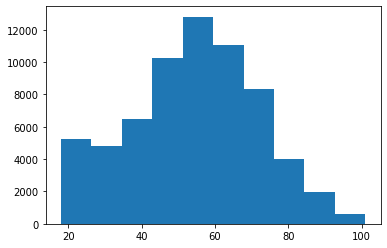

In [39]:
plt.hist(offer_recieved_df['age'])

plt.show()

# Data Analysis & Visualization

### _Get customers who recieved, viewed and completed an offer_

In [40]:


def customers_converted(offer_recieved_df, offer_viewed_df, offer_completed_df):
   
    """
    Creates a list of offers that were actually recieved, viewed and completed an offer(converted)
    
    Args:
        offer_recieved_df: dataframe of recieived offers  
        offer_viewed_df:  dataframe of viewed offers
        offer_completed_df: dataframe of offers completed
        
    Returns: 
        full_customers_converted_df: a dataframe of offer and customer data for customers who converted
        
    """  
    # subset to customer_id and offer_id
    recieved = offer_recieved_df[['customer_id', 'offer_id']]
    viewed = offer_viewed_df[['customer_id', 'offer_id']]
    completed = offer_completed_df[['customer_id', 'offer_id']]

    # do inner joins to get common
    recieved_viewed = recieved.merge(viewed, 
                                     how = 'inner', on = ['customer_id', 'offer_id'])
    recieved_viewed_completed = recieved_viewed.merge(completed, 
                                                      how = 'inner', on = ['customer_id', 'offer_id'])
    
    # remove duplicates
    recieved_viewed_completed.drop_duplicates(inplace=True)
    
    # join to the offer_completed_df to get all other columns
    full_customers_converted_df = offer_completed_df.merge(recieved_viewed_completed, 
                                                                 how = 'inner', on = ['customer_id', 'offer_id'])

    
    return full_customers_converted_df

In [41]:
# creating the converted offers
full_customers_converted_df = customers_converted(offer_recieved_df, offer_viewed_df, offer_completed_df)

print('The shape of the full_customers_converted_df is {0} and no of duplicates is {1}'.format(full_customers_converted_df.shape, full_customers_converted_df.columns.duplicated().sum()))

The shape of the full_customers_converted_df is (26909, 30) and no of duplicates is 0


In [42]:
print('Total percentage of customers who converted is {0}'.format(
    full_customers_converted_df['customer_id'].nunique()/offer_recieved_df['customer_id'].nunique() * 100
    )
)

Total percentage of customers who converted is 77.20427163198248


## Analysis: _Which demographic groubs respond to which offer type_

### Offer Type Vs Demographics - _Analysis to check how demographics influence the type of offer given_

In [43]:
def offer_type_analysis(df, dimension, title, xlabel):
    """
    Creates and saves a plot of the distiribution of offer type and demographics dimension of interest
    
    Args:
        df : a dataframe of the offers that converted
        dimension: the demographic column to group the data
        title: title of the plot
        xlabel : the x-axis label of the plot
        
    Returns:
        None 
        
    """
    
    summarized = df.groupby([dimension, 'offer_type'])['offer_id'].count().reset_index().rename(
        columns = {"offer_id" : "count"})
   
    summarized = summarized[summarized['count'] > 0]
    
    summarized_pivot = summarized.pivot(values ='count', columns ='offer_type',  index = dimension)
    
    stacked_data = summarized_pivot.apply(lambda x: x * 100/sum(x), axis=1)
    
    plt = stacked_data.plot(kind = 'bar', stacked=True, figsize = (25,10), 
                           rot = 1, fontsize = 15, color = ['black', '#00704A'])
    
    plt.legend(loc = 'upper center', fontsize = 9, title_fontsize = 13,
               ncol = 2, title = "Offer Type", prop={'size': 15})
    plt.set_title(title, fontsize = 20)
    plt.set_xlabel(xlabel, fontsize = 18)
    plt.set_ylabel("Percentage", fontsize = 18)  
    for rect in plt.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        label_text = round(height,2)

        # plt.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2
        plt.text(label_x, label_y, label_text, ha ='center', va ='center', color = 'white')
    
    path = 'plots/'
    file_extension = '.png'
    
    plt.figure.savefig(path + title + file_extension, dpi = 300,facecolor = 'w', edgecolor = 'w')
    

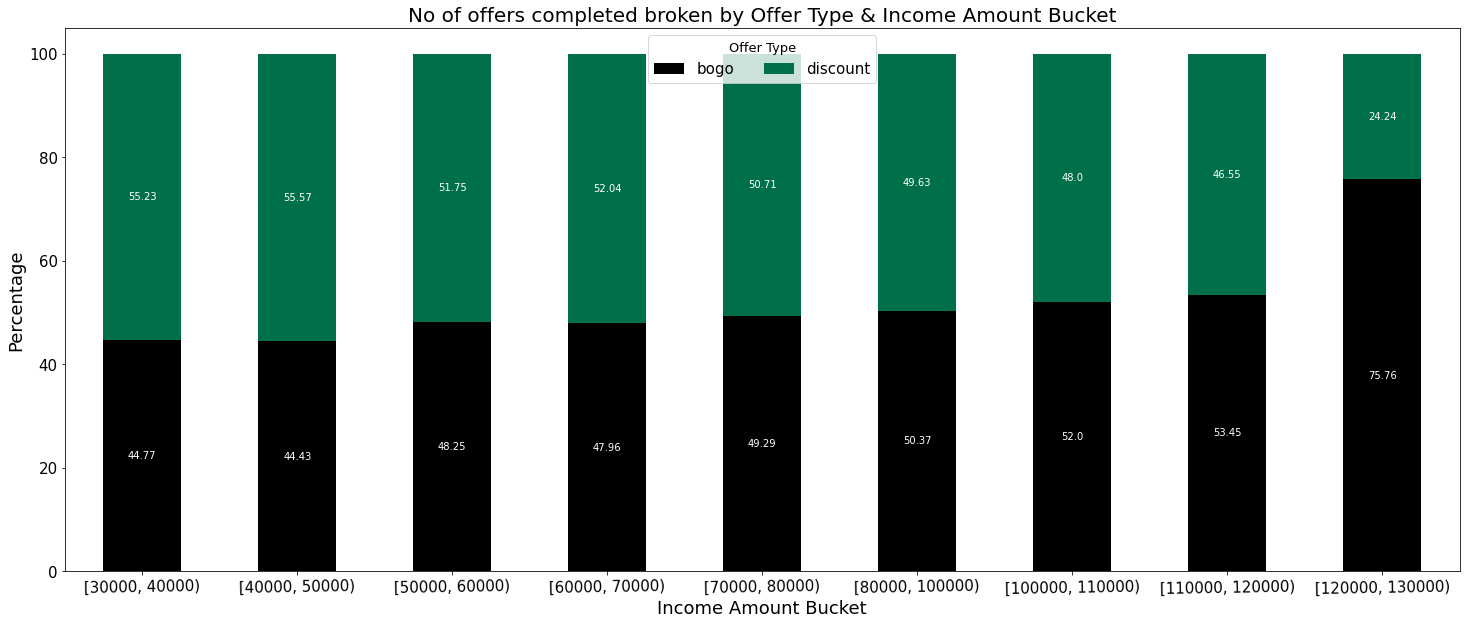

In [44]:
# Offer Type Vs Customer income buckets

offer_type_analysis(full_customers_converted_df, 'income_bucket', 'No of offers completed broken by Offer Type & Income Amount Bucket', 'Income Amount Bucket')

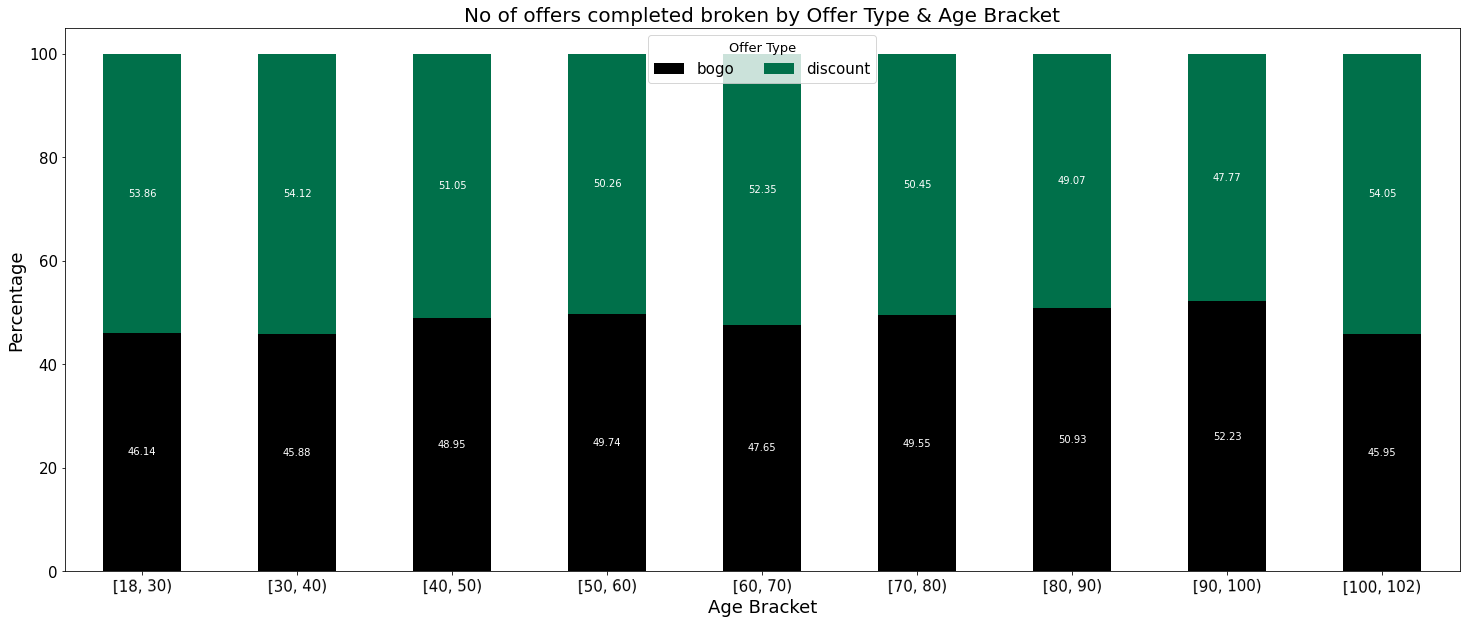

In [45]:
offer_type_analysis(full_customers_converted_df, 'age_group', 'No of offers completed broken by Offer Type & Age Bracket', 'Age Bracket')

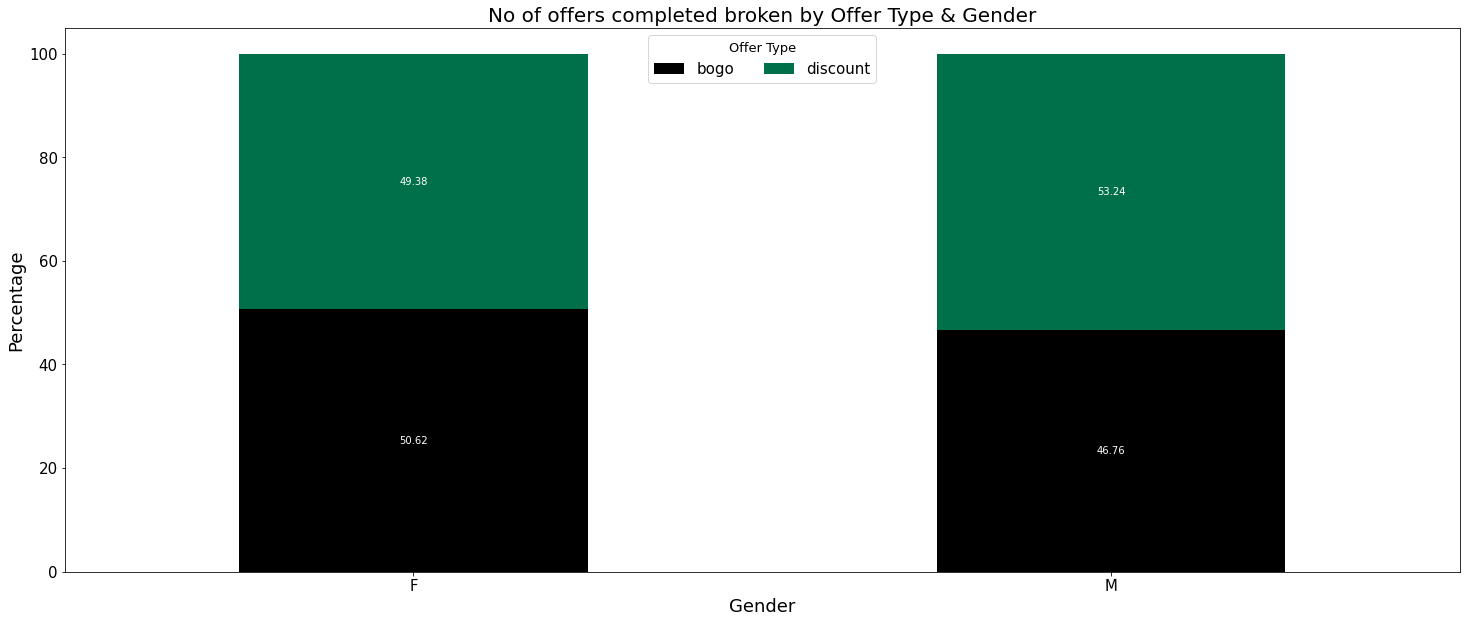

In [46]:
# Offer Type Vs Gender of customer
offer_type_analysis(full_customers_converted_df, 'gender', 'No of offers completed broken by Offer Type & Gender', 'Gender')

### Channel Vs Demographics - _Analysis to check how demographics influence the channels that a customer uses to complete an offer_

In [65]:
def channel_analysis(df, dimension, title, ylabel):
    
    """
    Creates and saves a horizontal bar graph plot of the distiribution of channels and demographics 
    dimension of interest
    
    Args:
        df : a dataframe of the offers that converted
        dimension: the demographic column to group the data
        title: title of the plot
        ylabel : the y-axis label of the plot
        
    Returns:
        None 
        
    """
    
    summarized = df.groupby([dimension, 'channels_list'])['offer_id'].count().reset_index().rename(
        columns = {"offer_id" : "count"})
   
    summarized = summarized[summarized['count'] > 0]
    
    summarized_pivot = summarized.pivot_table(values ='count', columns ='channels_list',  index = dimension, fill_value = 0)
    
    stacked_data = summarized_pivot.apply(lambda x: x * 100/sum(x), axis=1)
    
    plt = stacked_data.plot(kind = 'barh', stacked=True, figsize = (25,10), 
                           rot = 1, fontsize = 15, color = ['black', '#00704A', 'orange', 'maroon'])
    
    plt.legend(loc = 'upper left', title = "Channel", fontsize = 9, title_fontsize = 13,
               ncol = 1, bbox_to_anchor=(0.95, 0.5), prop={'size': 15}) 
    plt.set_title(title, fontsize = 20)
    plt.set_xlabel("Percentage", fontsize = 18)
    plt.set_ylabel(ylabel, fontsize = 18)  
    for rect in plt.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        label_text = round(width,2)

        # plt.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2
        plt.text(label_x, label_y, label_text, ha ='center', va ='center', color = 'white')
    
    path = 'plots/'
    file_extension = '.png'
    
    plt.figure.savefig(path + title + file_extension, facecolor = 'w', edgecolor = 'w')

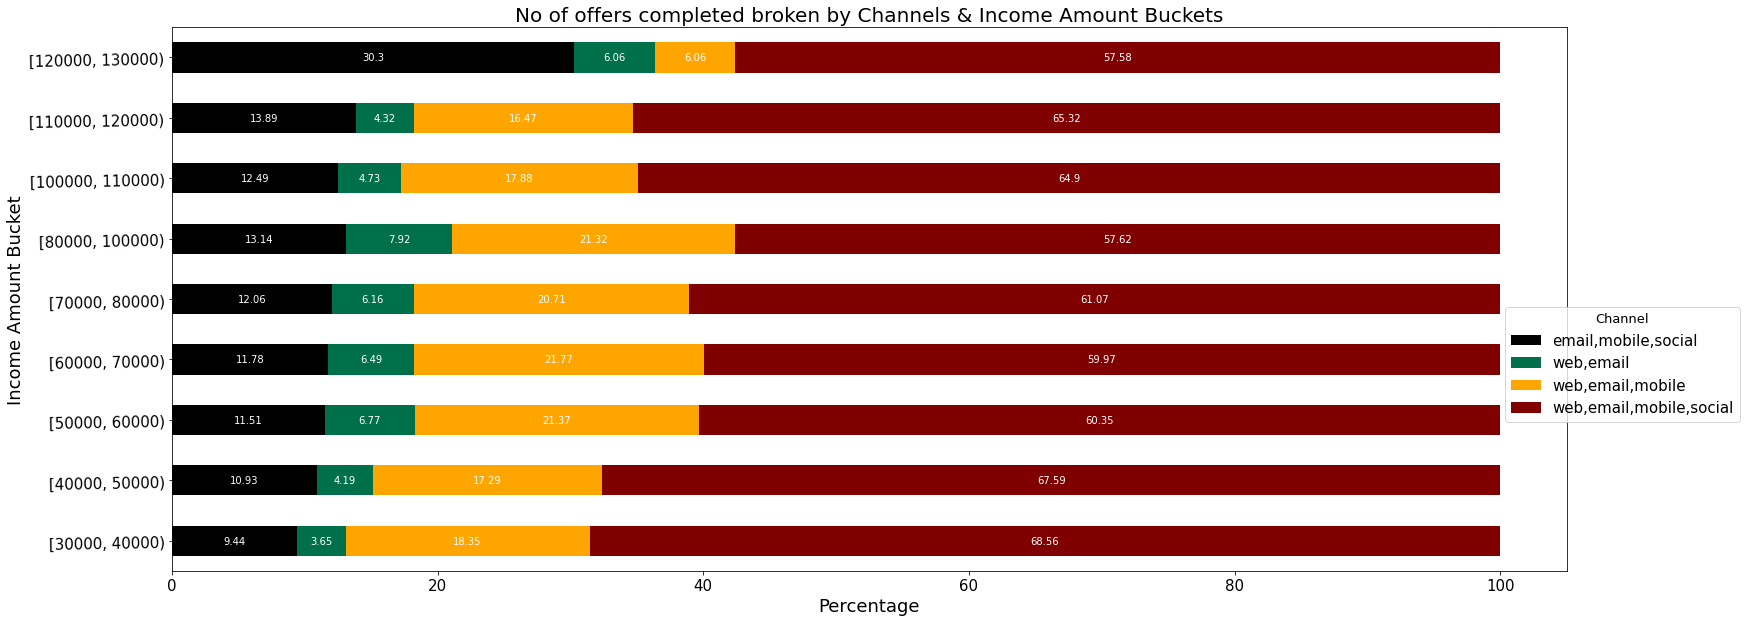

In [66]:
# Channel of offer Vs Demographics

channel_analysis(full_customers_converted_df, 'income_bucket', 'No of offers completed broken by Channels & Income Amount Buckets', 'Income Amount Bucket')

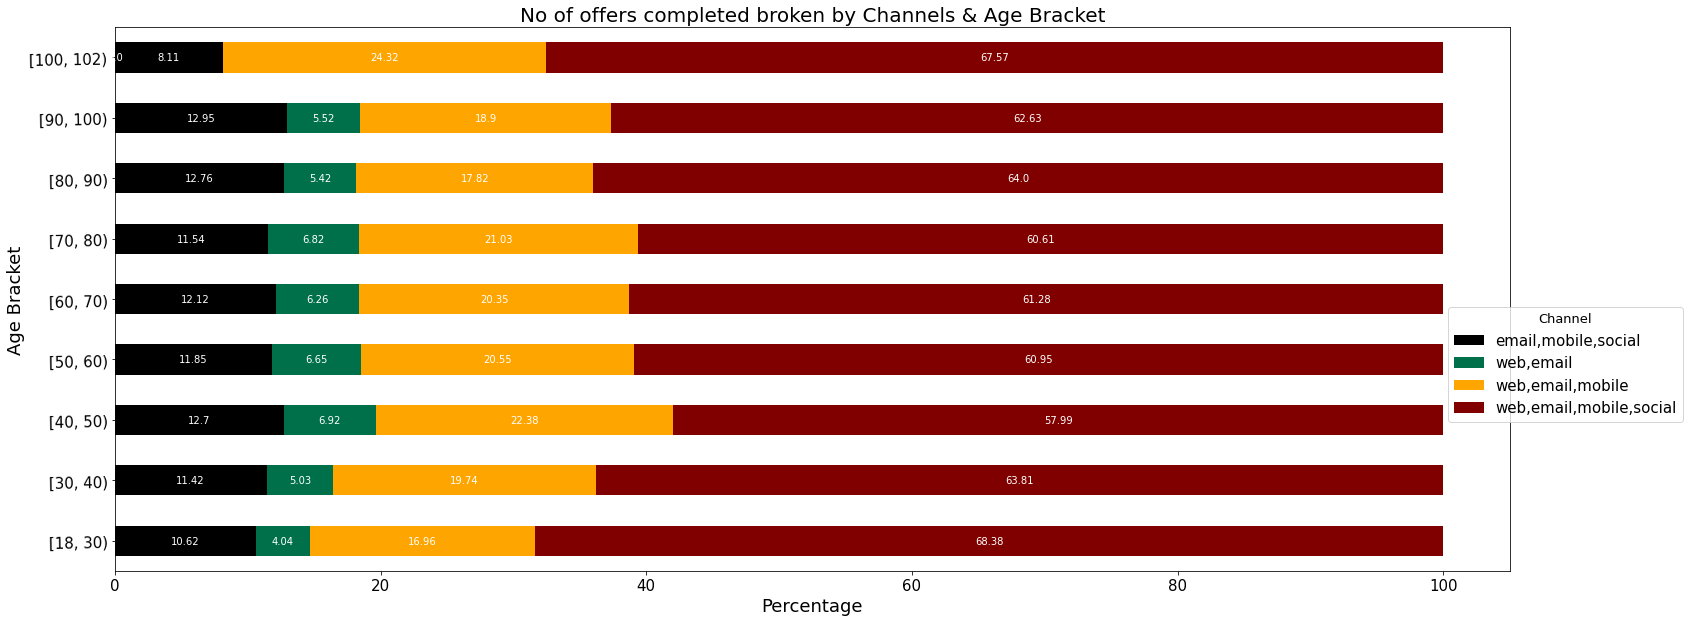

In [67]:
# Channel of Offer Vs Age group
channel_analysis(full_customers_converted_df, 'age_group', 'No of offers completed broken by Channels & Age Bracket', 'Age Bracket')

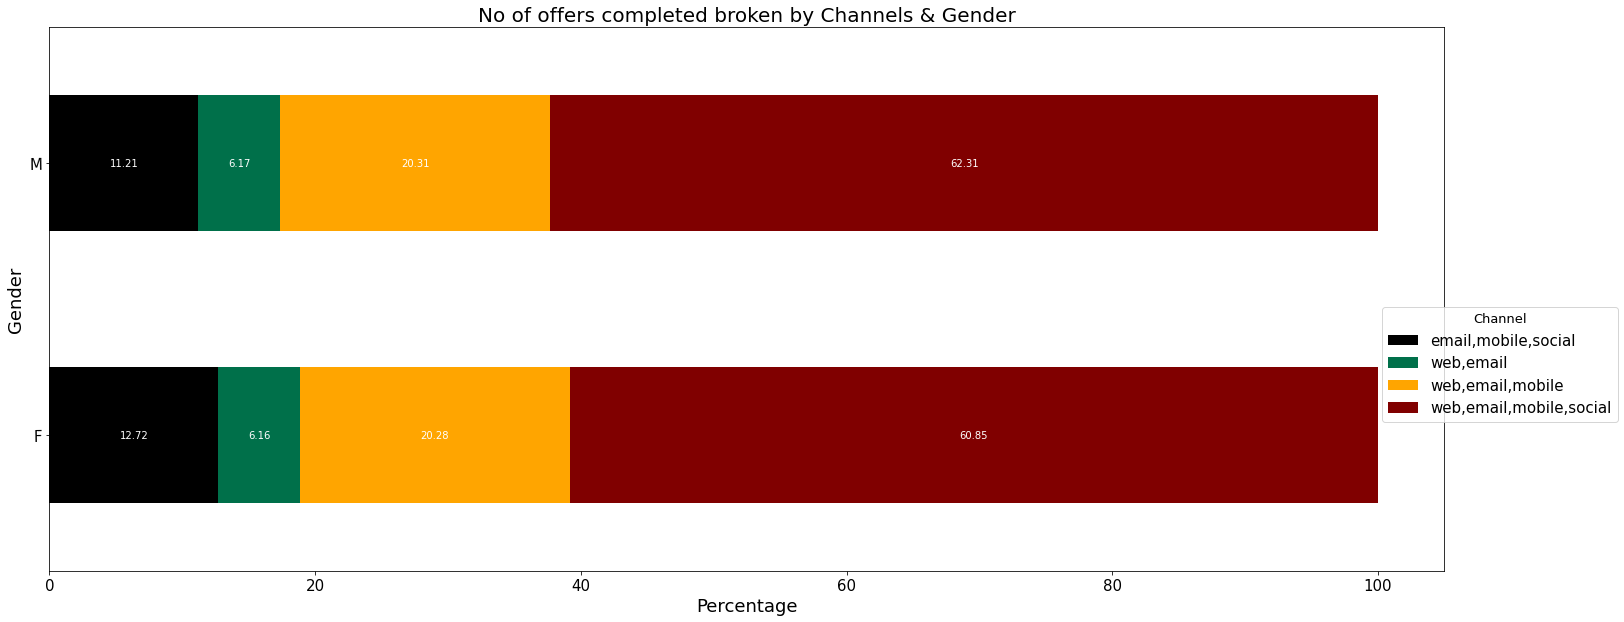

In [722]:
# Channel of Offer Vs Gender
channel_analysis(full_customers_converted_df, 'gender', 'No of offers completed broken by Channels & Gender', 'Gender')

### Duration of Offer Vs Demographics - _Analysis to understand how demogrpahics influence the customers completing offers of various durations_

In [715]:
def offer_duration_analysis(df, dimension, title, xlabel):
    """
    Creates and saves a horizontal bar graph plot of the distiribution of duration of offer and demographics 
    dimension of interest
    
    Args:
        df : a dataframe of the offers that converted
        dimension: the demographic column to group the data
        title: title of the plot
        xlabel : the x-axis label of the plot
        
    Returns:
        None 
        
    """

    summarized = df.groupby([dimension, 'duration'])['offer_id'].count().reset_index().rename(
        columns = {"offer_id" : "count"})
   
    summarized = summarized[summarized['count'] > 0]
    
    summarized_pivot = summarized.pivot(values ='count', columns ='duration',  index = dimension)
    
    stacked_data = summarized_pivot.apply(lambda x: x * 100/sum(x), axis=1)
    
    plt = stacked_data.plot(kind = 'bar', stacked = True, figsize = (25,10), 
                           rot = 1, fontsize = 15, color = ['black', '#00704A', 'maroon'])
    
    plt.legend(loc = 'upper left', title = "Duration", fontsize = 9, title_fontsize = 13,
               ncol = 1, bbox_to_anchor = (1.0, 0.5), prop = {'size': 15}) 
    plt.set_title(title, fontsize = 20)
    plt.set_xlabel(xlabel, fontsize = 18)
    plt.set_ylabel("Percentage", fontsize = 18)  
    for rect in plt.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        label_text = round(height,2)

        # plt.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2
        plt.text(label_x, label_y, label_text, ha ='center', va ='center', color = 'white')
    
    path = 'plots/'
    file_extension = '.png'
    
    plt.figure.savefig(path + title + file_extension, facecolor = 'w', edgecolor = 'w')

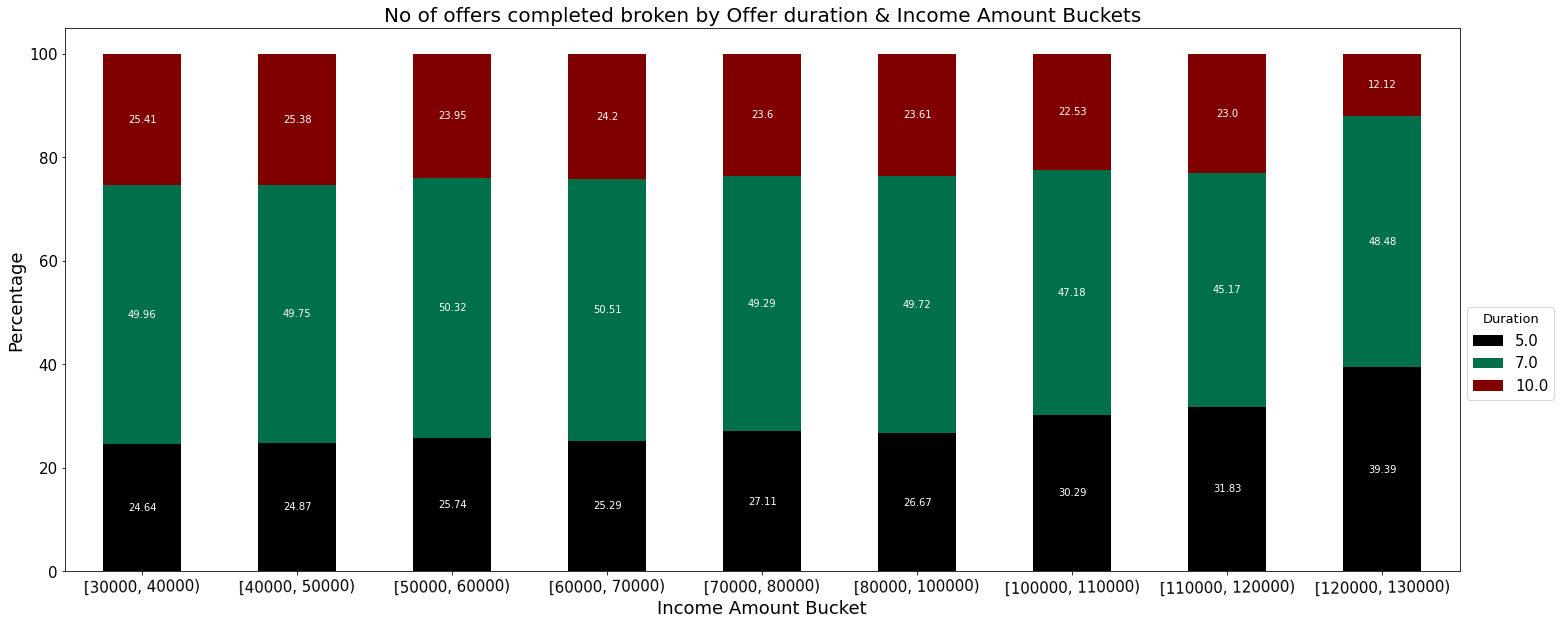

In [716]:
# Duration of Offer Vs Income bucket
offer_duration_analysis(full_customers_converted_df, 'income_bucket', 'No of offers completed broken by Offer duration & Income Amount Buckets', 'Income Amount Bucket')

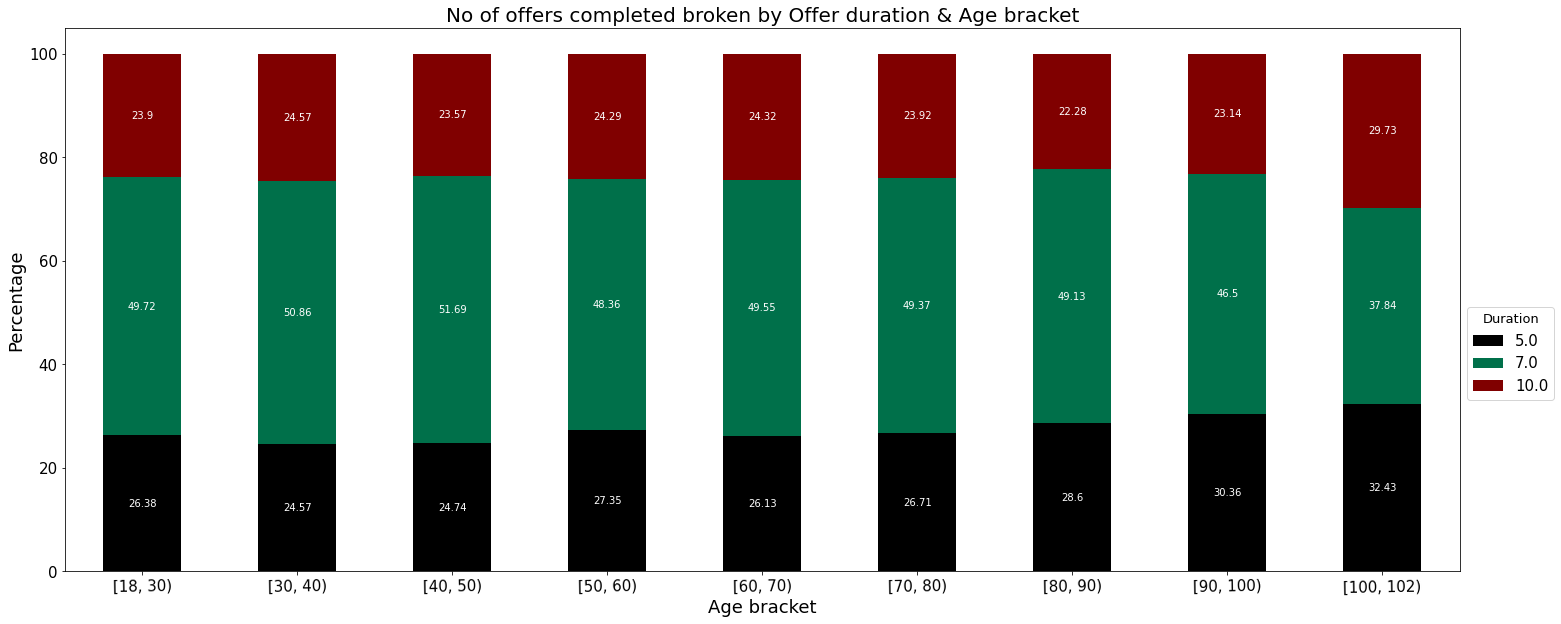

In [717]:
# Duration of Offer Vs Age group
offer_duration_analysis(full_customers_converted_df, 'age_group', 'No of offers completed broken by Offer duration & Age bracket', 'Age bracket')

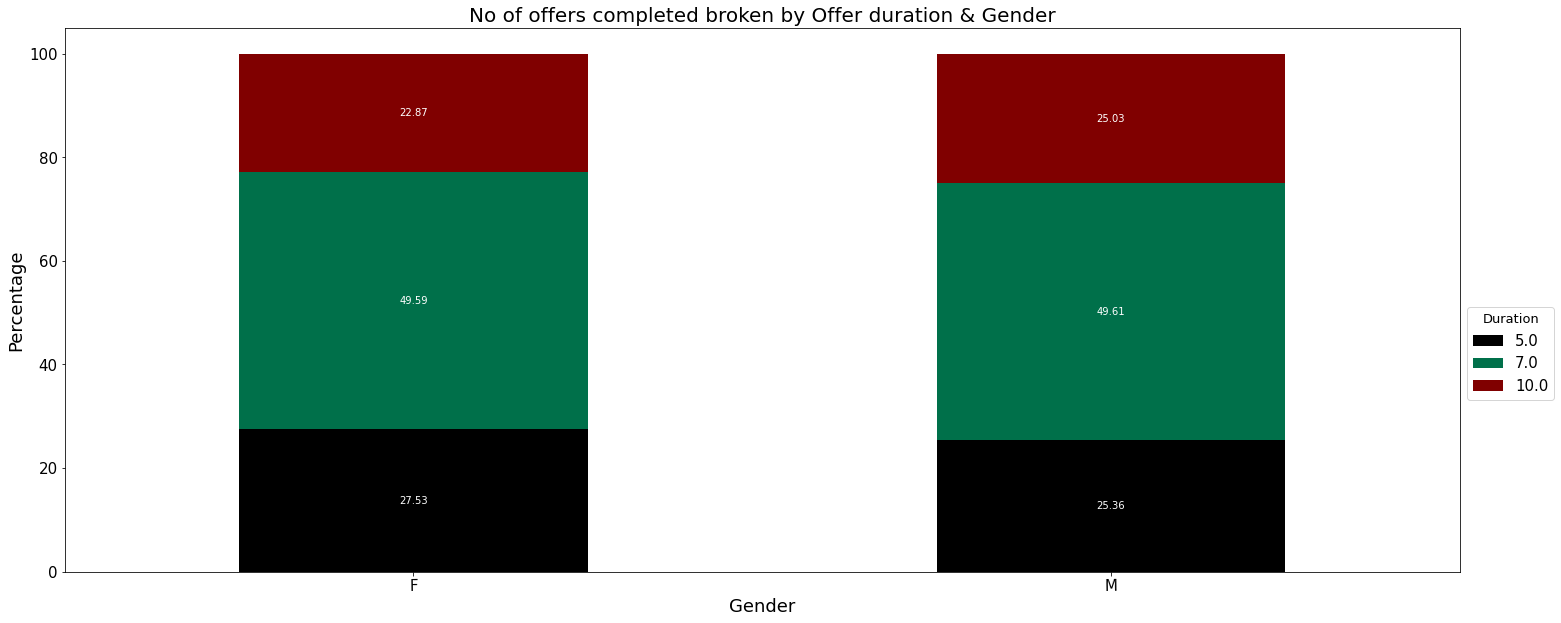

In [718]:
# Duration of Offer Vs Gender
offer_duration_analysis(full_customers_converted_df, 'gender', 'No of offers completed broken by Offer duration & Gender', 'Gender')

### Offer Reward Vs Demographics - _Analysis to investigate how demographics influence the customers in completing offers with various rewards_

In [711]:
def offer_reward_analysis(df, dimension, title, xlabel):
    """
    Creates and saves a horizontal bar graph plot of the distiribution of offer reward and demographics 
    dimension of interest
    
    Args:
        df : a dataframe of the offers that converted
        dimension: the demographic column to group the data
        title: title of the plot
        xlabel : the x-axis label of the plot
        
    Returns:
        None 
        
    """    
    summarized = df.groupby([dimension, 'portfolio_reward'])['offer_id'].count().reset_index().rename(
        columns = {"offer_id" : "count"})
   
    summarized = summarized[summarized['count'] > 0]
    
    summarized_pivot = summarized.pivot(values ='count', columns ='portfolio_reward',  index = dimension)
    
    stacked_data = summarized_pivot.apply(lambda x: x * 100/sum(x), axis=1)
    
    plt = stacked_data.plot(kind = 'bar', stacked = True, figsize = (25,10), 
                           rot = 1, fontsize = 15, color = ['black', '#00704A', 'orange', 'maroon'])
    
    plt.legend(loc = 'upper left', title = "Reward", fontsize = 9, title_fontsize = 13,
               ncol = 1, bbox_to_anchor = (1.0, 0.5), prop = {'size': 15}) 
    plt.set_title(title, fontsize = 20)
    plt.set_xlabel(xlabel, fontsize = 18)
    plt.set_ylabel('Percentage', fontsize = 18)  
    for rect in plt.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        label_text = round(height,2)

        # plt.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2
        plt.text(label_x, label_y, label_text, ha ='center', va ='center', color = 'white')
    
    path = 'plots/'
    file_extension = '.png'
    
    plt.figure.savefig(path + title + file_extension, facecolor = 'w', edgecolor = 'w')

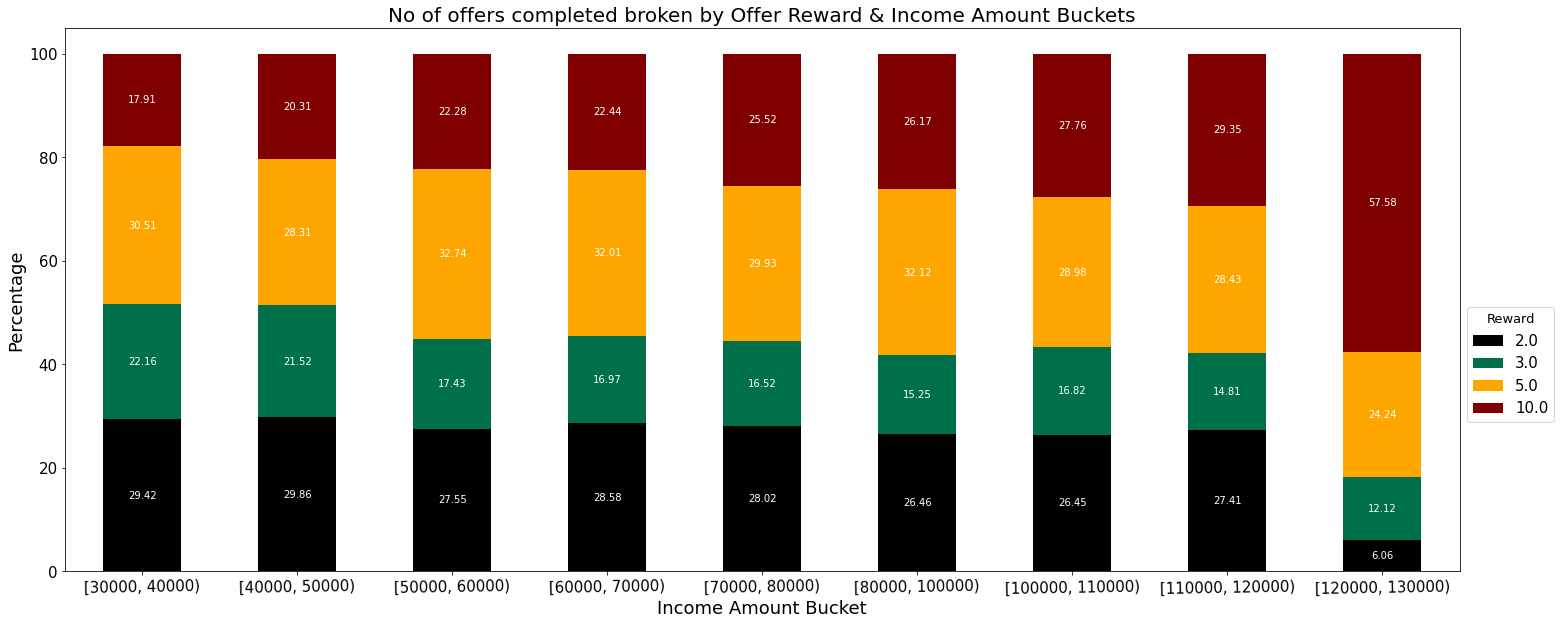

In [712]:
# Reward of Offer Vs Income brackets
offer_reward_analysis(full_customers_converted_df, 'income_bucket', 'No of offers completed broken by Offer Reward & Income Amount Buckets', 'Income Amount Bucket')

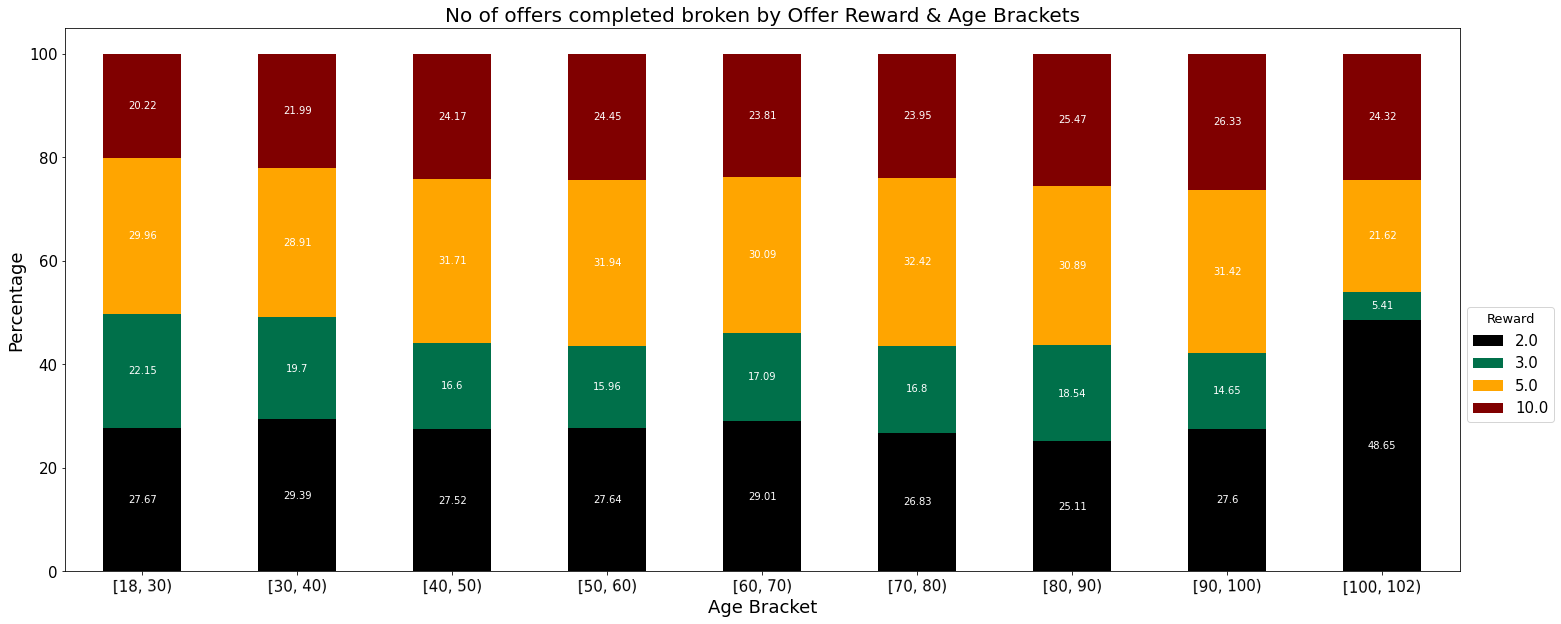

In [713]:
# Reward of Offer Vs Income brackets
offer_reward_analysis(full_customers_converted_df, 'age_group', 'No of offers completed broken by Offer Reward & Age Brackets', 'Age Bracket')

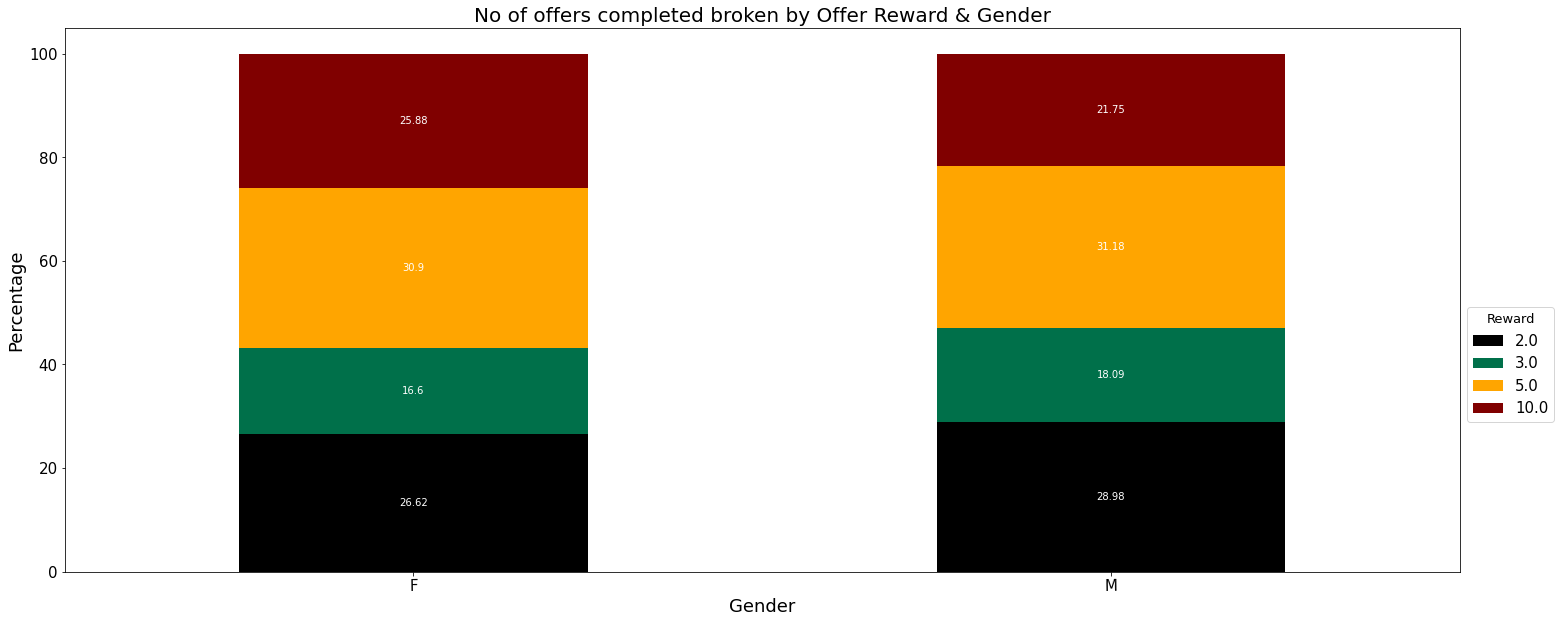

In [714]:
# Reward of Offer Vs Gender
offer_reward_analysis(full_customers_converted_df, 'gender', 'No of offers completed broken by Offer Reward & Gender', 'Gender')

### Offer Difficulty Vs Demographics - _Analysis to look into how demographics of customers interact with difficulty (min required spend to complete an offer) of offers_

In [707]:
def offer_difficulty_analysis(df, dimension, title, xlabel):
    
    """
    Creates and saves a horizontal bar graph plot of the distiribution of offer difficulty and demographics 
    dimension of interest
    
    Args:
        df : a dataframe of the offers that converted
        dimension: the demographic column to group the data
        title: title of the plot
        xlabel : the x-axis label of the plot
        
    Returns:
        None 
        
    """
    

    summarized = df.groupby([dimension, 'difficulty'])['offer_id'].count().reset_index().rename(
        columns = {"offer_id" : "count"})
   
    summarized = summarized[summarized['count'] > 0]
    
    summarized_pivot = summarized.pivot(values ='count', columns ='difficulty',  index = dimension)
    
    stacked_data = summarized_pivot.apply(lambda x: x * 100/sum(x), axis=1)
    
    plt = stacked_data.plot(kind = 'bar', stacked = True, figsize = (25,10), 
                           rot = 1, fontsize = 15, color = ['black', '#00704A', 'orange', 'maroon'])
    
    plt.legend(loc = 'upper left', title = 'Difficulty', fontsize = 9, title_fontsize = 13,
               ncol = 1, bbox_to_anchor = (1.0, 0.5), prop = {'size': 15}) 
    plt.set_title(title, fontsize = 20)
    plt.set_xlabel(xlabel, fontsize = 18)
    plt.set_ylabel('Percentage', fontsize = 18)  
    for rect in plt.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        label_text = round(height,2)

        # plt.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2
        plt.text(label_x, label_y, label_text, ha ='center', va ='center', color = 'white')
    
    path = 'plots/'
    file_extension = '.png'
    
    plt.figure.savefig(path + title + file_extension, facecolor = 'w', edgecolor = 'w')

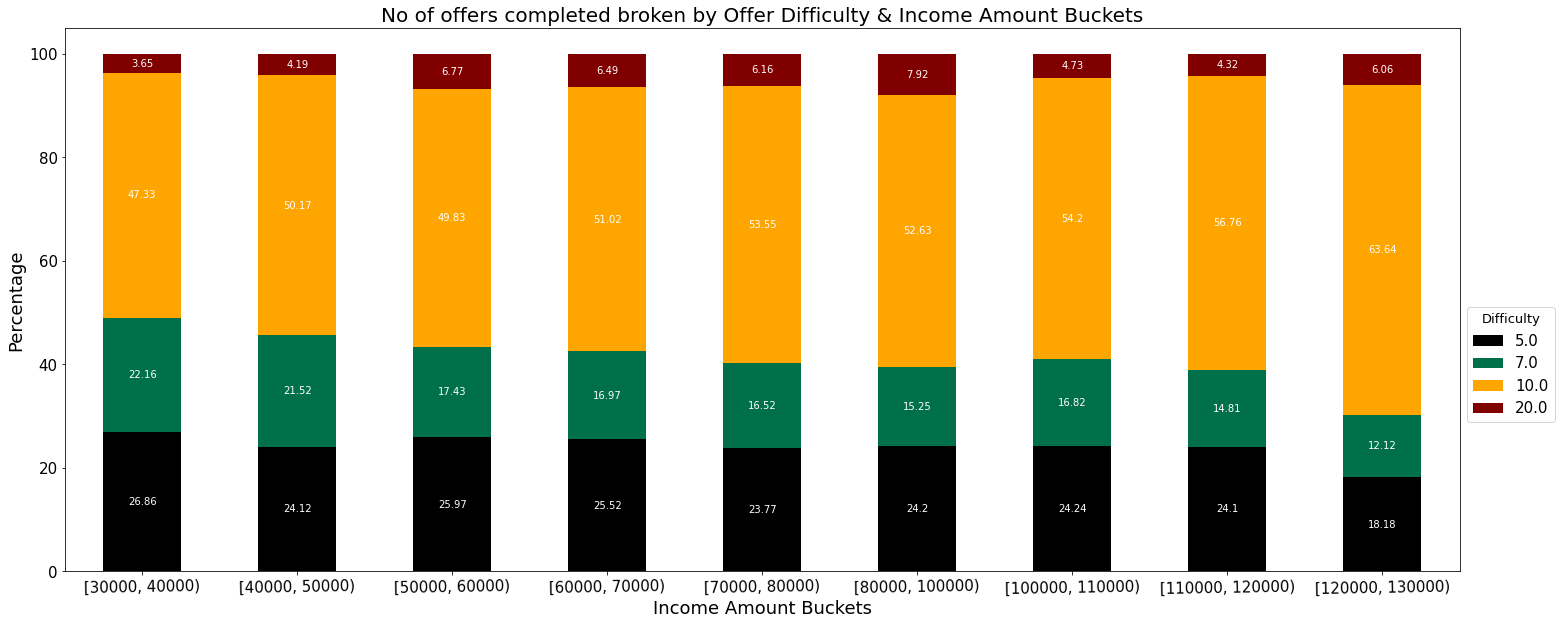

In [708]:
# Offer Difficulty Vs Income buckets
offer_difficulty_analysis(full_customers_converted_df, 'income_bucket', 'No of offers completed broken by Offer Difficulty & Income Amount Buckets', 'Income Amount Buckets')

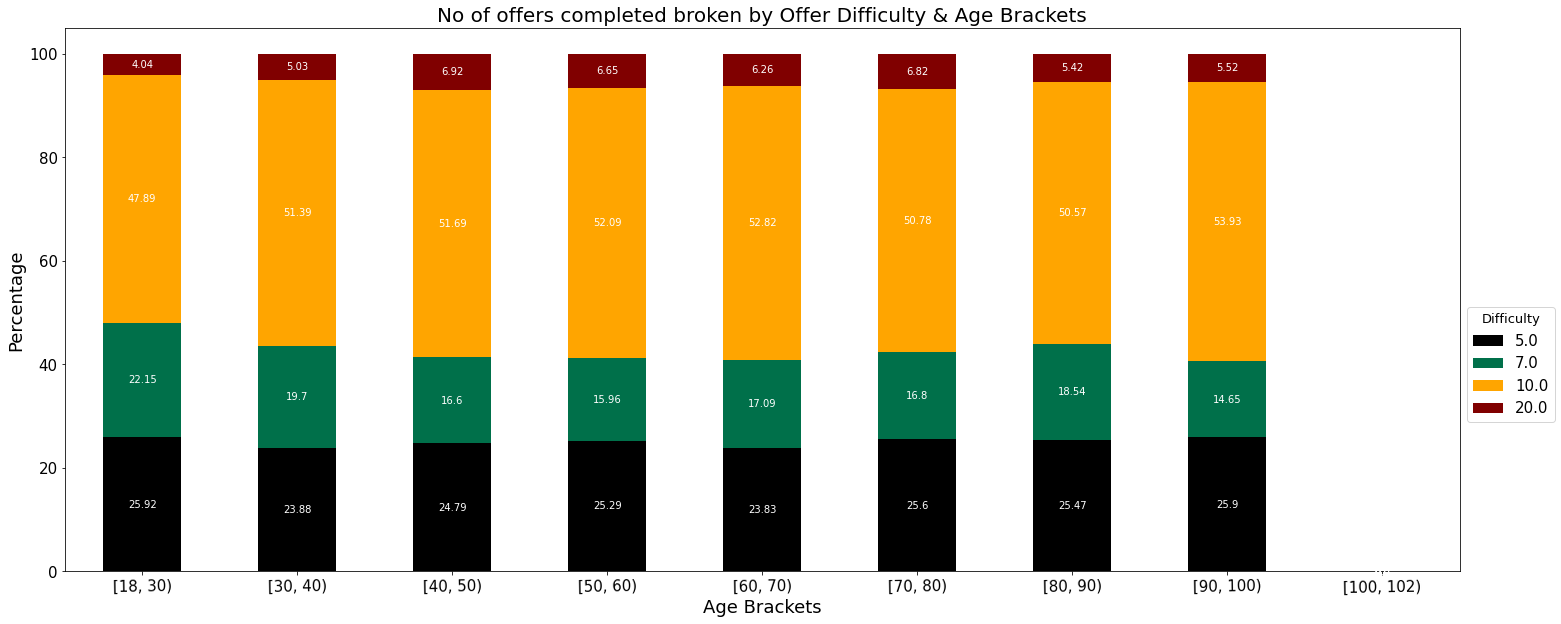

In [709]:
# Offer Difficulty Vs  Age Brackets
offer_difficulty_analysis(full_customers_converted_df, 'age_group', 'No of offers completed broken by Offer Difficulty & Age Brackets', 'Age Brackets')

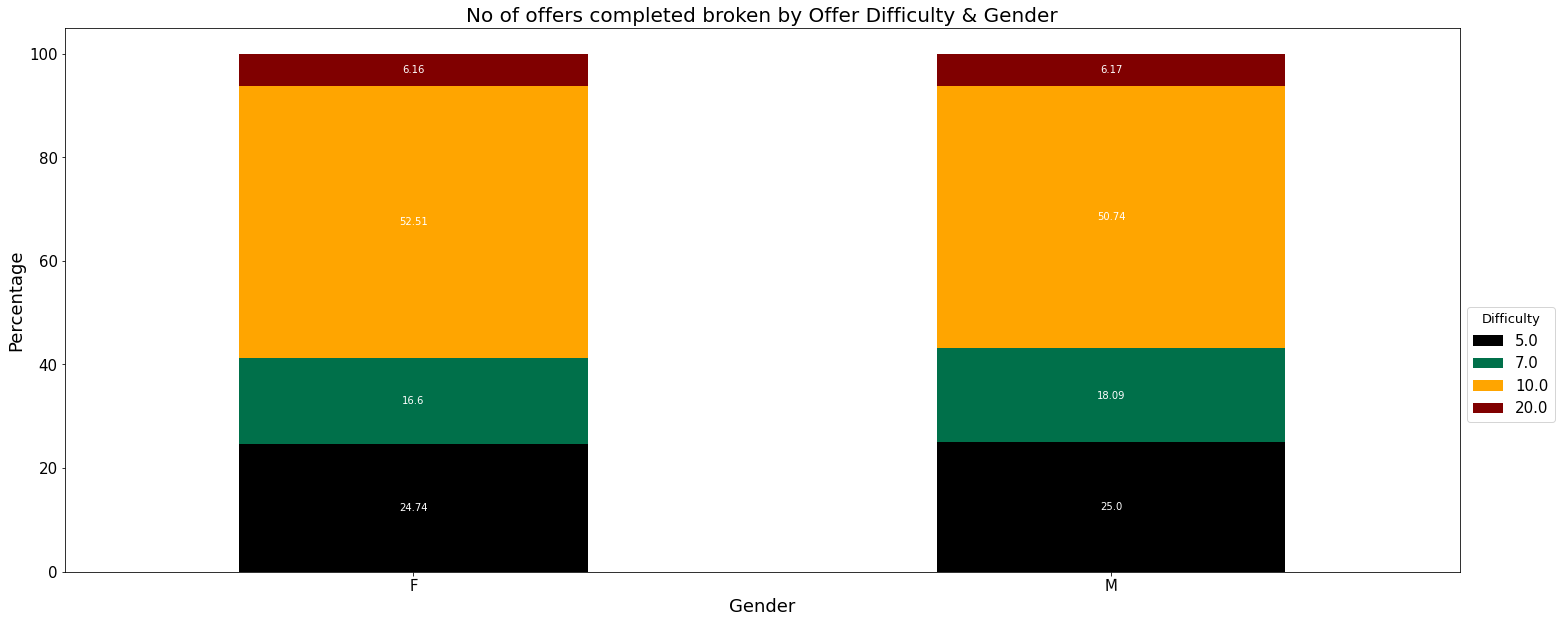

In [710]:
# Offer Difficulty Vs Gender
offer_difficulty_analysis(full_customers_converted_df, 'gender', 'No of offers completed broken by Offer Difficulty & Gender', 'Gender')

## Analysis: _Which factors influence highest to the amount spent by a customer_ ?

In [84]:
def relative_importance_analysis(df):    
    """
    Calculates scores to quantify the relative importance of individual drivers 
    in predicting an outcome variable
    
    Args:
        dataframe: a dataframe containing input data of the normalized driver columns and the target column
        
    Returns:
        df_results: a dataframe containing the results of the key driver importance analysis
            columns:
                driver: names of the driver variables
                rawRelaImpt: the raw relative importance whose sum equals R-squared
                normRelaImpt: the normalized relative importance whose sum equals one 
                
    """
    # get the features/drivers names to be analyzed
    features = ['time', 'age', 'gender_M', 'gender_F', 'income', 
                'day_became_member', 'month_became_member', 'year_became_member']
    
    # get the target column naame
    target = 'amount'
    
    # subset dataframe to get feature columns of interest
    subset_df = df[['time', 'age', 'gender_M', 'gender_F', 'income',
                    'day_became_member', 'month_became_member', 'year_became_member']]
    
    # noramlizing features dataset 
    subset_df_copy = subset_df.copy()                
    scaler = MinMaxScaler() 
    scaled_values = scaler.fit_transform(subset_df_copy) 
    subset_df_copy.loc[:,:] = scaled_values
    
    #creating a dataframe of normlized feature columns and amount column
    final_df = pd.concat([subset_df_copy, df[['amount']]], axis = 1)
    
    # calculate relative importance scores
    df_results = relativeImp(final_df, outcomeName = target, driverNames = features)
    
    # order the results dataframe
    df_results = df_results.sort_values('normRelaImpt', ascending = False)
    
    return df_results

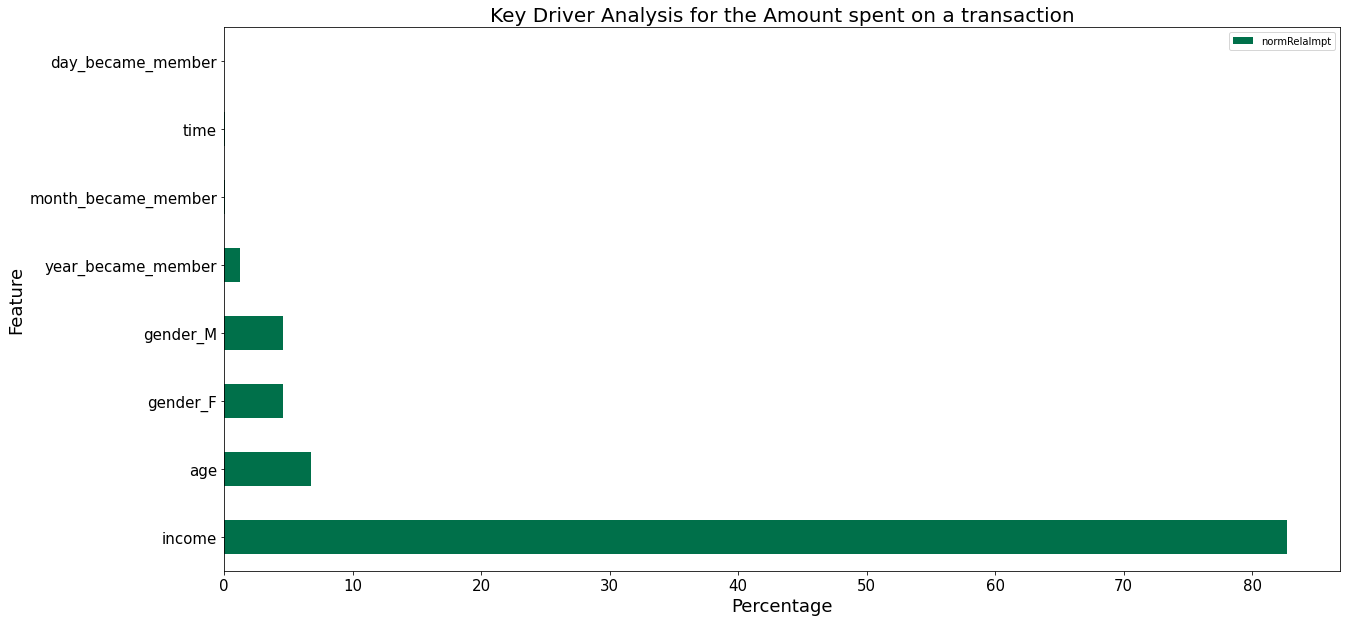

In [85]:
results = relative_importance_analysis(transaction_df)

plt = results.plot(kind = 'barh', x = 'driver', y = 'normRelaImpt', figsize = (20,10), 
                   rot=0, fontsize = 15, color = '#00704A')
plt.set_title('Key Driver Analysis for the Amount spent on a transaction', fontsize = 20)
plt.set_xlabel('Percentage', fontsize = 18)
plt.set_ylabel('Feature',fontsize = 18) 
plt.figure.savefig('plots/Key Driver Analysis for the Amount spent on a transaction', facecolor = 'w', edgecolor = 'w')


## References

Stackoverflow : https://stackoverflow.com/